# Binary classification for Sleep stages
## Using machine learning

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score


import mne
from mne.datasets.sleep_physionet.age import fetch_data


In [4]:
EVENT_ID = {
    'Awake': 1,
    'Sleeping': 2,
}

FREQ_BANDS = {'delta': [0.5, 4.5],
              'theta': [4.5, 8.5],
              'alpha': [8.5, 11.5],
              'sigma': [11.5, 15],
              'beta': [15, 30],
              }


In [5]:
def load_data(participant_id, event_id = EVENT_ID):
  """will load 30 secs epochs for each participant

  Parameters
  ----------

  participant_id:
    The subjects to use

  Return
  ----------

  raw_edf
    contains edf with annotations
  events
    contains 30 secs events
  epochs
    30 secs epochs for each participant

  Limitations:
  ----------
  WIll only get one recording session
  Will only work for 1 subect at a time

  """

  ANNOTATION_EVENT_ID = {
      "Sleep stage W": 1,
      "Sleep stage 1": 2,
      "Sleep stage 2": 2,
      "Sleep stage 3": 2,
      "Sleep stage 4": 2,
      "Sleep stage R": 2,
  }

  [participant_file] = fetch_data(subjects=[participant_id], recording=[1])
  raw_edf = mne.io.read_raw_edf(
      participant_file[0],
      preload=True,
      verbose='error',
      stim_channel='Event Marker',
      infer_types= True,
      )

  annotation_edf = mne.read_annotations(participant_file[1])
  #keep last 4 hour wake events before sleep nd first 4 hpurs wake events after sleep and redefine annotations

  annotation_edf.crop(annotation_edf[1]['onset'] - 30*240, annotation_edf[-2]['onset'] + 30*240)

  #attach the annotation file to the raw edf
  raw_edf.set_annotations(annotation_edf, emit_warning=False)

  #chunk the data into 30 secs epochs
  events, _ = mne.events_from_annotations(
      raw_edf, event_id= ANNOTATION_EVENT_ID, chunk_duration=30.0)

  #create the epochs so we can use it for classification
  tmax = 30.0 - 1.0 / raw_edf.info['sfreq']

  epochs = mne.Epochs(
      raw = raw_edf,
      events = events,
      event_id = event_id,
      tmin = 0.0,
      tmax = tmax,
      baseline = None,
      preload = True,
)

  return raw_edf, events, epochs

  raw_train, events_train, epochs_train = load_data(participant_id = 0)
  raw_test, events_test, epochs_test = load_data(participant_id = 1)

In [6]:
raw_train, events_train, epochs_train = load_data(participant_id = 0)
raw_test, events_test, epochs_test = load_data(participant_id = 1)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating /Users/uzermughal/mne_data


/Users/uzermughal/Documents/neuro-physiological data analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 21.8GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 9.36MB/s]

Download complete in 01m35s (46.1 MB)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1201 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 51.1M/51.1M [00:00<00:00, 24.4GB/s]
100%|█████████████████████████████████████| 3.90k/3.90k [00:00<00:00, 4.08MB/s]

Download complete in 01m49s (48.7 MB)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
1463 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1463 events and 3000 original time points ...
0 bad epochs dropped


Using matplotlib as 2D backend.


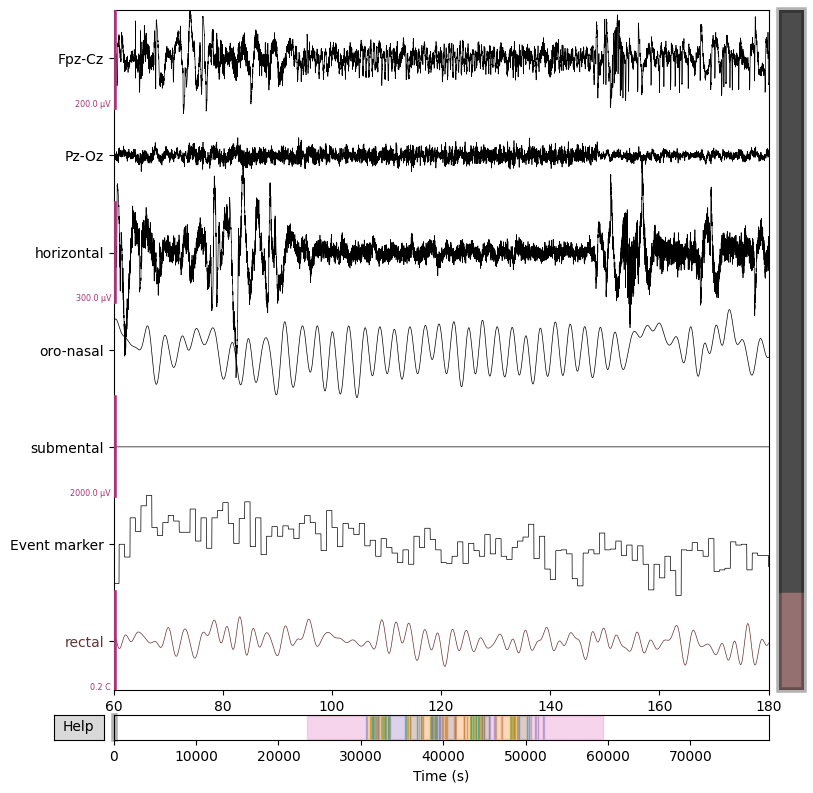

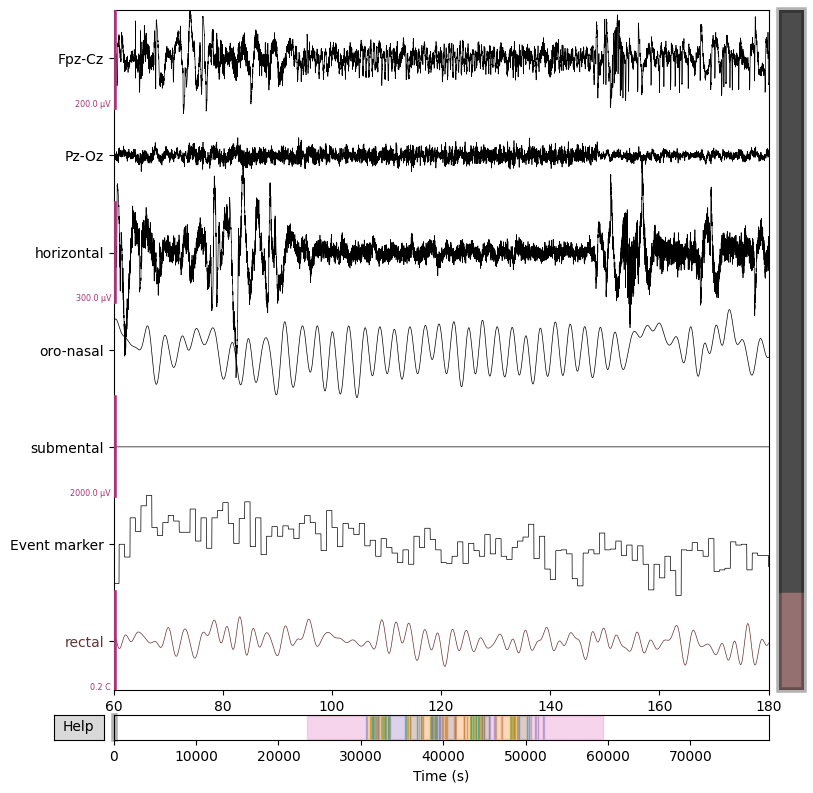

In [7]:
raw_train.plot(
    start = 60,
    duration = 120,
    scalings = {'eeg': 100e-6 , 'resp': 1e3, 'misc': 1e-1, }
)

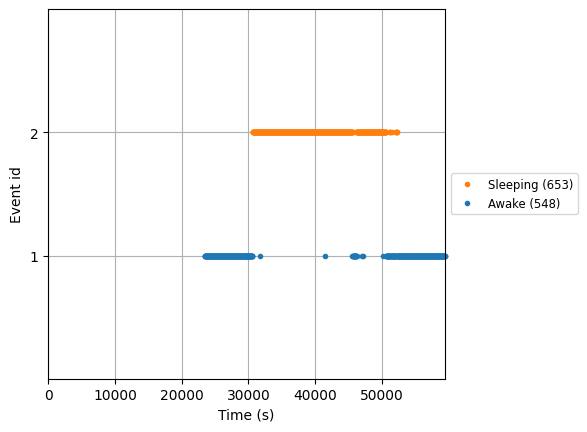

In [8]:
#plot events across time
fig = mne.viz.plot_events(
    events_train,
    event_id=EVENT_ID,
    sfreq=raw_train.info['sfreq'],
    first_samp=raw_train.first_samp)

ax = fig.gca()
ax.set_title('Participant 0 Annotated Events')
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


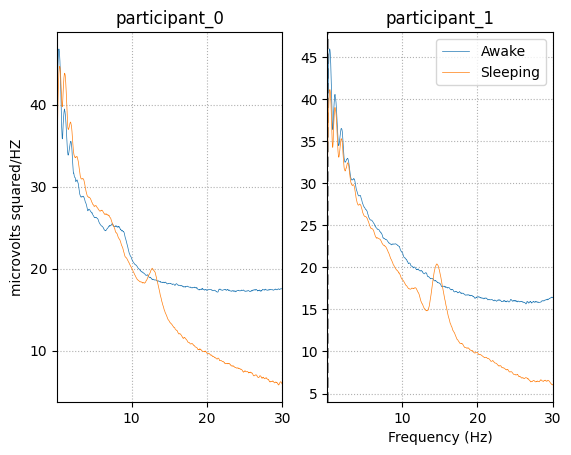

In [9]:
fig,(ax1,ax2) = plt.subplots(ncols=2,nrows=1)

#iterate over the subjects
stages= sorted(EVENT_ID.keys())

for ax,titles,epochs in zip([ax1,ax2],['participant_0','participant_1'],[epochs_train,epochs_test]):
  for stage, color, in zip(stages, stage_colors):
    spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=30)
    spectrum.plot(axes=ax,
                       ci = None,
                       color=color,
                       show=False,
                       #title=stage,
                       average=True,
                       picks='data',
                       spatial_colors=False,
                       exclude = 'bads'
                       )
    ax.set_title(titles) # Set the title for the subplot instead


ax.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('microvolts squared/HZ')
ax2.legend(ax2.lines[2::3], stages)
plt.show()


# Feature Calculation

In [10]:
def eeg_power_band(epochs, freq_bands = FREQ_BANDS):
  """Calculte relative spectral analysis for eaach epcoh """

  # Calculate Spectogram
  spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalize by frequency
  psds /= np.sum(psds, axis=-1, keepdims=True)

  # Shape of Psds:
  # (epoch, number of channels(we have 2), frequency bins)
  # We need to slice and average to get the delta to theta bands (5 features per channel)
  # Therefore our resulting psd shape will be (epoch, no. of channels(2) * frequency bands(5))
  X = []
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # Return a numpy array, by reshuffling the list from a (5, 841, 2) to a (841,10)
  return np.concatenate(X, axis=1)


# Classification

In [11]:
# Define what is random fo reach stage given the data we have
# Find the percentage of being awake and being asleep for both train and test
stages = sorted(EVENT_ID.keys())
n_epochs_train = len(epochs_train)
n_epochs_test = len(epochs_test)

print(stages)
print(EVENT_ID)
print('n_epochs_train',n_epochs_train)
print('n_epochs_test',n_epochs_test)

['Awake', 'Sleeping']
{'Awake': 1, 'Sleeping': 2}
n_epochs_train 1201
n_epochs_test 1463


In [ ]:
random_guess_train = {}
for stage in stages:
  random_guess_train[stage] = len(epochs_train[stage]) / n_epochs_train
print(random_guess_train)

{'Awake': 0.4562864279766861, 'Sleeping': 0.5437135720233139}


In [13]:
random_guess_test = {}
for stage in stages:
  random_guess_test[stage] = len(epochs_test[stage]) / n_epochs_test
print(random_guess_test)

{'Awake': 0.3533834586466165, 'Sleeping': 0.6466165413533834}


In [14]:
import pandas as pd

df = pd.DataFrame(epochs_train.events[:, 2])
df.count()
df.value_counts()

0
2    653
1    548
Name: count, dtype: int64

In [15]:
# Our Steps:
# 1. Create our feature vector X using the epochs
# 2. Make a random forest classifier

pipe = make_pipeline(
    FunctionTransformer(eeg_power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state= 42)
)

# Train the Classifier using participant 0
X_train = epochs_train
y_train = epochs_train.events[:, 2]
pipe.fit(X_train, y_train)

# Tesing using participant 1 data

X_test = epochs_test
y_test = epochs_test.events[:, 2]
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc*100:.2f}%')



    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy: 84.83%


# Result Analysis

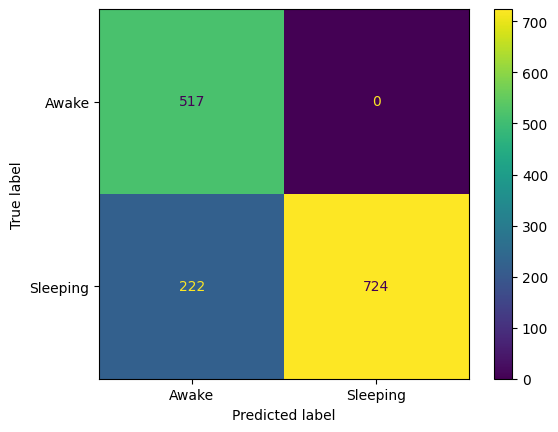

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stages)
disp.plot()
plt.show()